In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from nltk.corpus import stopwords
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.pipeline import make_pipeline

In [2]:
true0 = pd.DataFrame(pd.read_csv('./true.csv'))
fake0 = pd.DataFrame(pd.read_csv('./fake.csv'))

In [3]:
true0.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
fake0.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [5]:
fake_politics = fake0[fake0.subject.isin(['Government News', 'politics'])]
true_politics = true0[true0.subject == 'politicsNews']

In [6]:
# Filter the news of 2016
fake_politics_2016 = fake_politics[fake_politics['date'].str.contains('2016')]
true_politics_2016 = true_politics[true_politics['date'].str.contains('2016')]

In [7]:
fake1 = fake_politics_2016
true1 = true_politics_2016

In [8]:
fake1['label']=0
true1['label']=1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
news=fake1.append(true1)

In [10]:
news.head()

,title,text,subject,date,label
12023,TRUMP DITCHES PRESS To Make “Last Minute” Surp...,President-elect Donald Trump played a round of...,politics,"Dec 31, 2016",0
12024,"COUNTDOWN TICKER: Obama Leaves Office In…5,4,3...",(function(){ var s=document.createElement('scr...,politics,"Dec 31, 2016",0
12025,BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...,,politics,"Dec 31, 2016",0
12026,"YES, OBAMA…There Is A Magic Wand! [Video]",,politics,"Dec 31, 2016",0
12027,HA! DONALD TRUMP’S Unusual New Year’s Tweet To...,President-elect Donald Trump is throwing a pri...,politics,"Dec 31, 2016",0


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
#data cleaning

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing punctuation
def remove_punctuation(text):
    pattern = '[’!"#$%&\'()*+,-./:;<=>?@[\\]"^_`{|}~]+' 
    text = re.sub(pattern,'',text)
    return text

#Since 'reuters' is shown in almost every piece of true news, we want to remove it from the true news
def remove_reuters(text):
    if 'reuters' in text.split()[0:5]:
        text = text[text.find('reuters'):]
        text = text.split(' ', 1)[1]
    return text
    

#Removing the noisy text
def denoise_text(text):
    text.lower()
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_reuters(text)
      
    return text


In [14]:
#Apply function on text and title column
news['text']=news['text'].apply(denoise_text)
news['title']=news['title'].apply(denoise_text)

C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=IioEIUmawRo" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=31MRqr9ydUU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=wYdX071Nlow" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the doc

In [15]:
# drop those empty text data 
news = news[news.text != '']

In [16]:
# Shuffle the news
news = news.sample(frac = 1, random_state = 1)

In [17]:
news.head(10)

,title,text,subject,date,label
9917,mississippi governor signs law allowing armed ...,mississippi governor phil bryant signed gun ri...,politicsNews,"April 15, 2016",1
13107,watch cnn host freak onair “factcheck” proves ...,hangon hangon hangon hangon brooke baldwin des...,politics,"Sep 2, 2016",0
10519,kerry trip cuba rights dialogue canceled us of...,tentative plans us secretary state john kerry ...,politicsNews,"March 4, 2016",1
10945,special report obama gun control advocates sto...,barack obama might seem unlikely investor fire...,politicsNews,"February 5, 2016",1
10495,white house adviser rhodes meet cuban american...,president barack obamas deputy national securi...,politicsNews,"March 4, 2016",1
8137,us lawmakers say afghanistan corruption threat...,us senators questioned state department offici...,politicsNews,"September 15, 2016",1
14256,unhinged radical leftists try storm trumps uta...,utah protest planned organized far left effort...,politics,"Mar 19, 2016",0
13814,five state department rules hillary violated,hillary doubles false claim rules clarified le...,politics,"May 27, 2016",0
14165,witch hunt communist california raids home man...,make mistake it seeing tactics used communist ...,politics,"Apr 6, 2016",0
14448,gag hollywood latinos gush hillary nevada race...,pandering hillary best first black vote meetin...,politics,"Feb 20, 2016",0


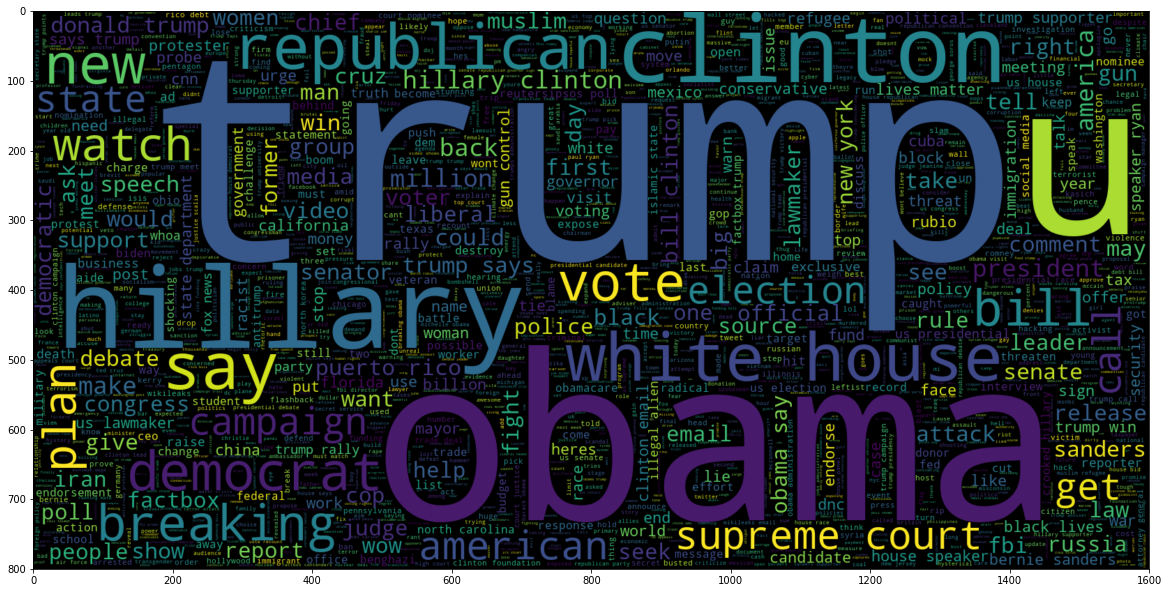

In [18]:
#wordcloud all news based on the titles
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(news.title))
plt.imshow(wc , interpolation = 'bilinear')

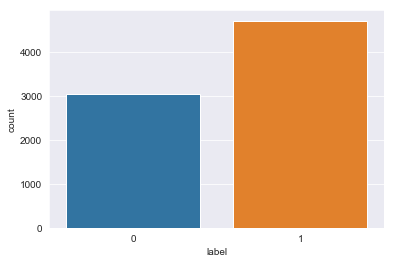

In [19]:
sns.set_style("darkgrid")
sns.countplot(news.label)

In [19]:
# select the title and text data
X = news[['title', 'text']]

In [20]:
# The outcome is always label
Y = news[['label']]

In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

In [22]:
# Split the data as two sources: title and text 
x_train_title = x_train['title']
x_train_text = x_train['text']
x_test_title = x_test['title']
x_test_text = x_test['text']

In [23]:
y_train = y_train['label']
y_test = y_test['label']

# 1. Prediction based on Title

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [34]:
# Model 1: Naive Bayes Model with TF-IDF inputs
model1_title = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_title.fit(x_train_title, y_train)
pred1_title = model1_title.predict(x_test_title)
f1_model1_title = f1_score(y_test, pred1_title, average = 'macro')

print('F1 score of model1_title:', f1_model1_title)

F1 score of model1_title: 0.9281289373295099


Text(27.6, 0.5, 'predicted label')

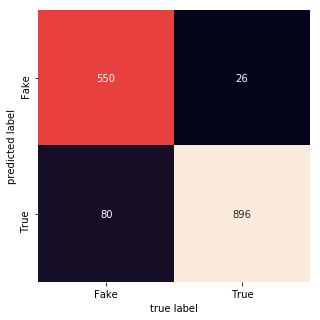

In [30]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_title)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


In [27]:
from sklearn.neural_network import MLPClassifier

In [31]:
# Model 2: Single Layer Neural Network Model with TF-IDF inputs
model2_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_title.fit(x_train_title, y_train)
pred2_title = model2_title.predict(x_test_title)
f1_model2_title = f1_score(y_test, pred2_title, average = 'macro')

Iteration 1, loss = 0.67931797
Iteration 2, loss = 0.58607968
Iteration 3, loss = 0.45919279
Iteration 4, loss = 0.33990822
Iteration 5, loss = 0.25078905
Iteration 6, loss = 0.18947957
Iteration 7, loss = 0.14758040
Iteration 8, loss = 0.11841614
Iteration 9, loss = 0.09669657
Iteration 10, loss = 0.08061329
Iteration 11, loss = 0.06804653
Iteration 12, loss = 0.05814917
Iteration 13, loss = 0.05024183
Iteration 14, loss = 0.04372418
Iteration 15, loss = 0.03837055
Iteration 16, loss = 0.03390911
Iteration 17, loss = 0.03015030
Iteration 18, loss = 0.02696851
Iteration 19, loss = 0.02423972
Iteration 20, loss = 0.02190843
Iteration 21, loss = 0.01992083
Iteration 22, loss = 0.01814972
Iteration 23, loss = 0.01662708
Iteration 24, loss = 0.01528897
Iteration 25, loss = 0.01409501
Iteration 26, loss = 0.01302000
Iteration 27, loss = 0.01207480
Iteration 28, loss = 0.01121923
Iteration 29, loss = 0.01049916
Iteration 30, loss = 0.00979514
Iteration 31, loss = 0.00917126
Iteration 32, los

In [33]:
print('F1 score of model2_title:', f1_model2_title)

F1 score of model2_title: 0.9431500606551619


In [37]:
# Model 3: Multi Layer Neural Network Model with TF-IDF inputs
model3_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ),random_state=1, verbose = True))
model3_title.fit(x_train_title, y_train)
pred3_title = model3_title.predict(x_test_title)
f1_model3_title = f1_score(y_test, pred3_title, average = 'macro')

Iteration 1, loss = 0.58296919
Iteration 2, loss = 0.10330109
Iteration 3, loss = 0.01375077
Iteration 4, loss = 0.00168248
Iteration 5, loss = 0.00049345
Iteration 6, loss = 0.00030998
Iteration 7, loss = 0.00025794
Iteration 8, loss = 0.00023576
Iteration 9, loss = 0.00022034
Iteration 10, loss = 0.00020969
Iteration 11, loss = 0.00020404
Iteration 12, loss = 0.00020012
Iteration 13, loss = 0.00019695
Iteration 14, loss = 0.00019417
Iteration 15, loss = 0.00019171
Iteration 16, loss = 0.00018949
Iteration 17, loss = 0.00018740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [38]:
print('F1 score of model3_title:', f1_model3_title)

F1 score of model3_title: 0.9406242007277541


In [6]:
# Model 4: Single Layer Neural Network Model with embedding inputs

#load word embeddings.

glove_file = datapath('/Users/luanyang/Downloads/stat software/hw/glove.6B.100d.txt')
word2vec_text_file = get_tmpfile("/Users/luanyang/Downloads/stat software/hw/glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_text_file)
model = KeyedVectors.load_word2vec_format(word2vec_text_file)
wv = model.wv

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [42]:
# Model 4: Single Layer Neural Network Model with embedding inputs

#load word embeddings.

glove_file = datapath('/Users/Administrator/Google Drive/Data Science/Stat Software/SS6/glove.6B.100d.txt')
word2vec_text_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_text_file)
model = KeyedVectors.load_word2vec_format(word2vec_text_file)
wv = model.wv

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [44]:
# get the embedding of the document 
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    doc_list = doc.lower().split()
    doc_embed = np.zeros(embed_size)
    length = 0
    for word in doc_list:
        if word in embeddings:
            doc_embed = doc_embed + embeddings[word]
            length += 1
        else:
            if word in OOV_embed:
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
            else:
                OOV_embed[word] = np.random.rand(embed_size)
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
    doc_embed = doc_embed / length
    return doc_embed

x_train_title_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_train_title])
x_test_title_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_test_title])

In [46]:
x_train_title_embed2 = np.vstack([calc_doc_embedding(doc, gloveModel, 100, {}) for doc in x_train_title])
x_test_title_embed2 = np.vstack([calc_doc_embedding(doc, gloveModel, 100, {}) for doc in x_test_title])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [53]:
model4_title = MLPClassifier(hidden_layer_sizes=(50), max_iter=500,verbose=True)
model4_title.fit(x_train_title_embed, y_train)
pred4_title = model4_title.predict(x_test_title_embed)
f1_macro = f1_score(y_test, pred4_title, average = 'macro')
f1_micro = f1_score(y_test, pred4_title, average = 'micro')

Iteration 1, loss = 0.56770523
Iteration 2, loss = 0.39960352
Iteration 3, loss = 0.34496795
Iteration 4, loss = 0.32179174
Iteration 5, loss = 0.30825546
Iteration 6, loss = 0.29904933
Iteration 7, loss = 0.29236830
Iteration 8, loss = 0.28605526
Iteration 9, loss = 0.28068455
Iteration 10, loss = 0.27631720
Iteration 11, loss = 0.27292351
Iteration 12, loss = 0.26956577
Iteration 13, loss = 0.26675336
Iteration 14, loss = 0.26457635
Iteration 15, loss = 0.26329031
Iteration 16, loss = 0.26047728
Iteration 17, loss = 0.25720349
Iteration 18, loss = 0.25655405
Iteration 19, loss = 0.25332617
Iteration 20, loss = 0.25728733
Iteration 21, loss = 0.25151624
Iteration 22, loss = 0.24949203
Iteration 23, loss = 0.24784628
Iteration 24, loss = 0.24688936
Iteration 25, loss = 0.24494267
Iteration 26, loss = 0.24518008
Iteration 27, loss = 0.24590770
Iteration 28, loss = 0.24061240
Iteration 29, loss = 0.23982298
Iteration 30, loss = 0.23917606
Iteration 31, loss = 0.23729616
Iteration 32, los

Iteration 256, loss = 0.05906013
Iteration 257, loss = 0.07030086
Iteration 258, loss = 0.06405762
Iteration 259, loss = 0.05694636
Iteration 260, loss = 0.05814506
Iteration 261, loss = 0.05597911
Iteration 262, loss = 0.05493762
Iteration 263, loss = 0.05393473
Iteration 264, loss = 0.05340815
Iteration 265, loss = 0.05285434
Iteration 266, loss = 0.05307652
Iteration 267, loss = 0.05232190
Iteration 268, loss = 0.05179350
Iteration 269, loss = 0.05107297
Iteration 270, loss = 0.05084258
Iteration 271, loss = 0.05035048
Iteration 272, loss = 0.05041742
Iteration 273, loss = 0.05063213
Iteration 274, loss = 0.04943580
Iteration 275, loss = 0.05023414
Iteration 276, loss = 0.05491560
Iteration 277, loss = 0.04970865
Iteration 278, loss = 0.04872790
Iteration 279, loss = 0.05004746
Iteration 280, loss = 0.04916574
Iteration 281, loss = 0.04719498
Iteration 282, loss = 0.04657725
Iteration 283, loss = 0.05078422
Iteration 284, loss = 0.04681689
Iteration 285, loss = 0.04574876
Iteration 

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [54]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.8989583333333333
microaveraged F1:  0.9020618556701031


In [55]:
# Model 5: Multi Layer Neural Network Model with embedding inputs

model5_title = MLPClassifier(hidden_layer_sizes=(200,200,200,200), max_iter=500,verbose=True)
model5_title.fit(x_train_title_embed, y_train)
pred5_title = model5_title.predict(x_test_title_embed)
f1_macro = f1_score(y_test, pred5_title, average = 'macro')
f1_micro = f1_score(y_test, pred5_title, average = 'micro')

Iteration 1, loss = 0.40843720
Iteration 2, loss = 0.27263461
Iteration 3, loss = 0.24740189
Iteration 4, loss = 0.22183675
Iteration 5, loss = 0.23067905
Iteration 6, loss = 0.18424165
Iteration 7, loss = 0.17238150
Iteration 8, loss = 0.14769987
Iteration 9, loss = 0.15300213
Iteration 10, loss = 0.15340013
Iteration 11, loss = 0.10616610
Iteration 12, loss = 0.08051784
Iteration 13, loss = 0.06859250
Iteration 14, loss = 0.04687189
Iteration 15, loss = 0.03157415
Iteration 16, loss = 0.02054054
Iteration 17, loss = 0.05285229
Iteration 18, loss = 0.02011020
Iteration 19, loss = 0.00892016
Iteration 20, loss = 0.00427884
Iteration 21, loss = 0.00200697
Iteration 22, loss = 0.00122471
Iteration 23, loss = 0.00083471
Iteration 24, loss = 0.00057446
Iteration 25, loss = 0.00052828
Iteration 26, loss = 0.00044290
Iteration 27, loss = 0.00039916
Iteration 28, loss = 0.00037253
Iteration 29, loss = 0.00034944
Iteration 30, loss = 0.00033247
Iteration 31, loss = 0.00031805
Iteration 32, los

In [56]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.901881271280583
microaveraged F1:  0.9052835051546392


In [53]:
# Model 6 : Simple RNN Model with Embeddings Input
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Bidirectional

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['title'])
word_index = tokenizer.word_index
max_vocab = len(word_index) + 1
# tokenize the text into vectors 
x_train_title_rnn = tokenizer.texts_to_sequences(x_train_title)
x_test_title_rnn = tokenizer.texts_to_sequences(x_test_title)

#Apply padding so we have the same length for each article
x_train_title_rnn = pad_sequences(x_train_title_rnn, maxlen=30)
x_test_title_rnn = pad_sequences(x_test_title_rnn, maxlen=30)

In [39]:
# Convert the raw embedding file to a dictionary.
f = open('glove.6B.100d.txt', 'r', encoding='UTF-8')
gloveModel = {}
for line in f:
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.asarray(splitLines[1:])
    gloveModel[word] = wordEmbedding

In [82]:
WordVector ={key:[float(number) for number in item] for key, item in gloveModel.items()}

In [85]:
WordVector['come'].shape

AttributeError: 'list' object has no attribute 'shape'

In [40]:
gloveModel['come']

array(['-0.088345', '0.59988', '0.59225', '-0.5246', '0.013373',
       '0.065076', '-0.17394', '0.24336', '-0.034376', '-0.30909',
       '-0.054752', '0.11497', '0.35605', '0.34198', '-0.14174',
       '-0.3729', '-0.032475', '0.60172', '-0.89721', '0.38812',
       '0.31088', '0.14001', '-0.048641', '0.0049248', '-0.1163',
       '0.10278', '-0.2872', '-0.43993', '0.50917', '-0.55447',
       '-0.20422', '0.081898', '-0.070066', '-0.11791', '0.14151',
       '0.64288', '0.051433', '-0.036541', '-0.02136', '-0.50186',
       '-0.57299', '-0.13418', '-0.39058', '-0.47298', '-0.43163',
       '-0.14637', '0.061678', '-0.022781', '0.1785', '-1.132', '0.07729',
       '-0.26659', '0.1185', '0.99549', '0.19061', '-2.3023', '-0.29906',
       '-0.088649', '1.6263', '0.18357', '-0.22593', '1.1956', '-0.58488',
       '-0.087597', '0.80774', '0.43632', '0.16536', '0.2351', '-0.31746',
       '-0.55406', '0.35451', '-0.48811', '-0.45092', '-0.96281',
       '0.054511', '0.10049', '-0.38566', 

In [84]:
wv['come'].shape

(100,)

In [58]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [80]:
dic = {'a':['2', '3'], 'b':['3','4'] }
dic2 = {key:[float(number) for number in item] for key, item in dic.items()}

In [81]:
dic2

{'a': [2.0, 3.0], 'b': [3.0, 4.0]}

In [89]:
model6 = Sequential(name = 'model6')
model6.add(Embedding(input_dim = len(word_index)+1, output_dim = 100, input_length=30, weights=[embedding_matrix], trainable=False))
model6.add(SimpleRNN(50))
model6.add(Dense(1, activation = 'sigmoid'))
model6.summary()

Model: "model6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 30, 100)           1220700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                7550      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 1,228,301
Trainable params: 7,601
Non-trainable params: 1,220,700
_________________________________________________________________


In [91]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model6_title = model6.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model6.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 1s 5ms/step - loss: 0.2097 - accuracy: 0.9174 - val_loss: 0.2327 - val_accuracy: 0.8986
Epoch 2/10
175/175 [==============================] - 1s 3ms/step - loss: 0.1843 - accuracy: 0.9303 - val_loss: 0.2220 - val_accuracy: 0.9050
Epoch 3/10
175/175 [==============================] - 1s 4ms/step - loss: 0.1724 - accuracy: 0.9330 - val_loss: 0.2267 - val_accuracy: 0.9098
Epoch 4/10
175/175 [==============================] - 1s 3ms/step - loss: 0.1550 - accuracy: 0.9411 - val_loss: 0.2174 - val_accuracy: 0.9147
Epoch 5/10
175/175 [==============================] - 1s 3ms/step - loss: 0.1403 - accuracy: 0.9491 - val_loss: 0.2199 - val_accuracy: 0.9211
Epoch 6/10
175/175 [==============================] - 1s 3ms/step - loss: 0.1210 - accuracy: 0.9577 - val_loss: 0.2215 - val_accuracy: 0.9147
Epoch 7/10
175/175 [==============================] - 1s 3ms/step - loss: 0.1080 - accuracy: 0.9629 - val_loss: 0.2369 - val_accuracy: 0.9147
Epoch 

[0.2068139910697937, 0.9207473993301392]

In [99]:
# Define a function which can visualize the accuracy and loss with time
def model_plot(model):

    history_dict = model.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = model.epoch

    plt.figure(figsize=(12,9))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=20)
    plt.xlabel('Epochs', size=20)
    plt.ylabel('Loss', size=20)
    plt.legend(prop={'size': 20})
    plt.show()

    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=20)
    plt.xlabel('Epochs', size=20)

    plt.ylabel('Accuracy', size=20)
    plt.legend(prop={'size': 20})
    plt.ylim((0.5,1))
    plt.show()

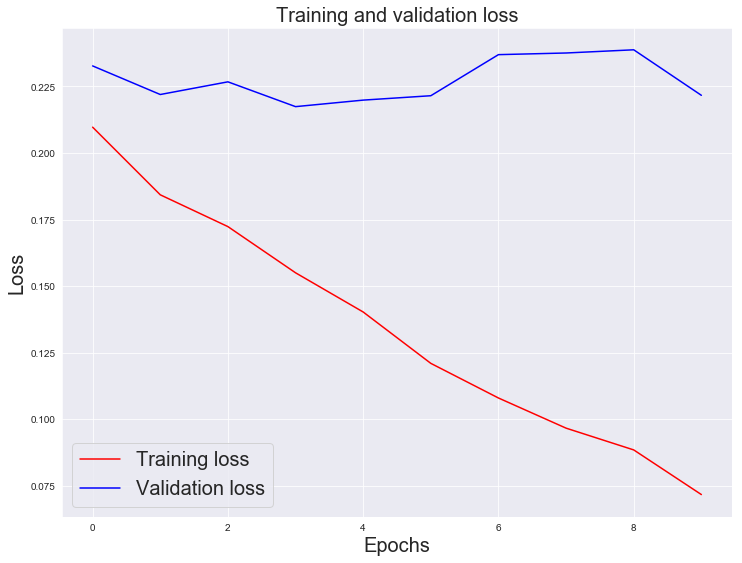

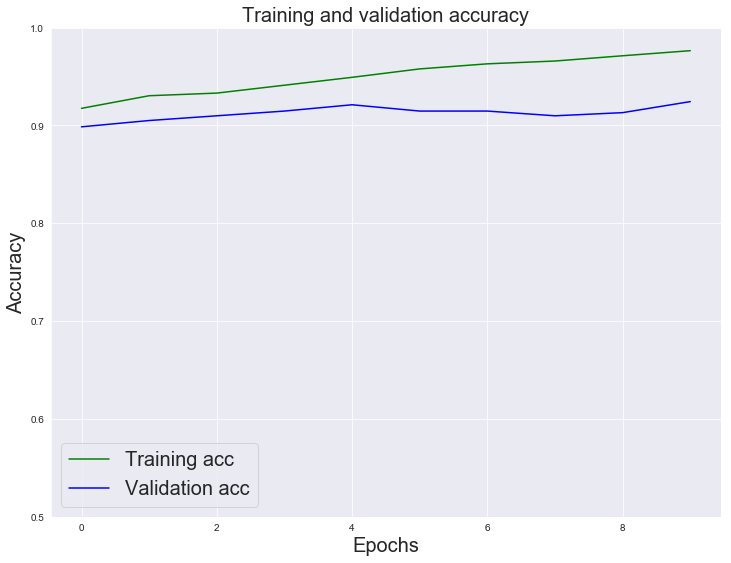

In [100]:
model_plot(model6_title)

In [95]:
# Define a function which can measure the macro_F1 score of RNN models
def rnn_f1(model, x_test_rnn):
    pred_prob = model.predict(x_test_rnn)
    pred = []
    
    for i in pred_prob:
        if i >= 0.5:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_macro = f1_score(y_test, pred, average = 'macro')
    
    return f1_macro

In [98]:
print('macroaveraged F1: ', rnn_f1(model6, x_test_title_rnn))

macroaveraged F1:  0.9174761793393893


In [109]:
# Model 7: Sophisticated RNN Model with Embedding Inputs
model7 = Sequential(name = 'model7')
model7.add(Embedding(input_dim = len(word_index)+1, output_dim = 100, input_length=30, weights=[embedding_matrix], trainable=False))
model7.add(Bidirectional(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
model7.add(Bidirectional(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2, return_sequences=False)))
model7.add(Dropout(rate=0.3))
model7.add(Dense(1, activation = 'sigmoid'))
model7.summary()

Model: "model7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 30, 100)           1220700   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 30, 200)           160800    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 201       
Total params: 1,622,501
Trainable params: 401,801
Non-trainable params: 1,220,700
_________________________________________________________________


In [105]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_title = model7.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model7.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 15s 86ms/step - loss: 0.3156 - accuracy: 0.8652 - val_loss: 0.2142 - val_accuracy: 0.9114
Epoch 2/10
175/175 [==============================] - 15s 84ms/step - loss: 0.2133 - accuracy: 0.9192 - val_loss: 0.1917 - val_accuracy: 0.9163
Epoch 3/10
175/175 [==============================] - 15s 85ms/step - loss: 0.1805 - accuracy: 0.9319 - val_loss: 0.1847 - val_accuracy: 0.9211
Epoch 4/10
175/175 [==============================] - 15s 86ms/step - loss: 0.1609 - accuracy: 0.9425 - val_loss: 0.1710 - val_accuracy: 0.9308
Epoch 5/10
175/175 [==============================] - 15s 86ms/step - loss: 0.1438 - accuracy: 0.9497 - val_loss: 0.1629 - val_accuracy: 0.9372
Epoch 6/10
175/175 [==============================] - 15s 86ms/step - loss: 0.1227 - accuracy: 0.9563 - val_loss: 0.1587 - val_accuracy: 0.9420
Epoch 7/10
175/175 [==============================] - 15s 86ms/step - loss: 0.1072 - accuracy: 0.9631 - val_loss: 0.1737 - val_accuracy:

[0.15030120313167572, 0.9484536051750183]

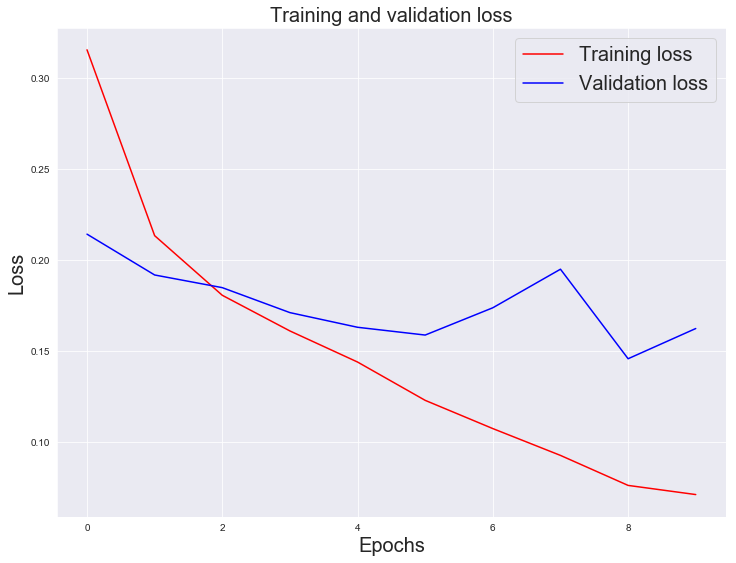

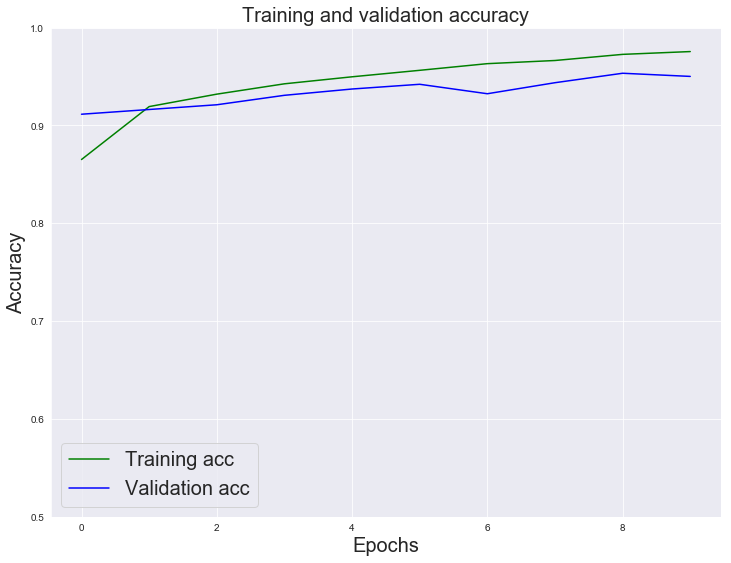

In [106]:
model_plot(model7_title)

In [107]:
print('macroaveraged F1: ', rnn_f1(model7, x_test_title_rnn))

macroaveraged F1:  0.9464528460726338


# 2. Prediction based on Text

In [57]:
# Model 1: Naive Bayes Model with TF-IDF inputs
model1_text = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_text.fit(x_train_text, y_train)
pred1_text = model1_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred1_text, average = 'macro')
f1_micro = f1_score(y_test, pred1_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.6561700963251216
microaveraged F1:  0.7287371134020618


In [58]:
# Model 2: Single Layer Neural Network Model with TF-IDF inputs
model2_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_text.fit(x_train_text, y_train)
pred2_text = model2_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred2_text, average = 'macro')
f1_micro = f1_score(y_test, pred2_text, average = 'micro')

Iteration 1, loss = 0.60506918
Iteration 2, loss = 0.40863560
Iteration 3, loss = 0.25178339
Iteration 4, loss = 0.15828300
Iteration 5, loss = 0.10529325
Iteration 6, loss = 0.07376747
Iteration 7, loss = 0.05396829
Iteration 8, loss = 0.04103129
Iteration 9, loss = 0.03210281
Iteration 10, loss = 0.02582662
Iteration 11, loss = 0.02131203
Iteration 12, loss = 0.01790139
Iteration 13, loss = 0.01529733
Iteration 14, loss = 0.01324577
Iteration 15, loss = 0.01164221
Iteration 16, loss = 0.01032906
Iteration 17, loss = 0.00924273
Iteration 18, loss = 0.00835967
Iteration 19, loss = 0.00761715
Iteration 20, loss = 0.00700036
Iteration 21, loss = 0.00647684
Iteration 22, loss = 0.00601770
Iteration 23, loss = 0.00562620
Iteration 24, loss = 0.00528585
Iteration 25, loss = 0.00498615
Iteration 26, loss = 0.00471851
Iteration 27, loss = 0.00447823
Iteration 28, loss = 0.00426447
Iteration 29, loss = 0.00407562
Iteration 30, loss = 0.00390248
Iteration 31, loss = 0.00374778
Iteration 32, los

In [59]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9738057371355868
microaveraged F1:  0.9748711340206185


In [61]:
# Model 3: Single Layer Neural Network Model with TF-IDF inputs
model3_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(100,100,100, ), random_state=1, verbose = True))
model3_text.fit(x_train_text, y_train)
pred3_text = model3_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred3_text, average = 'macro')
f1_micro = f1_score(y_test, pred3_text, average = 'micro')

Iteration 1, loss = 0.54850161
Iteration 2, loss = 0.12517372
Iteration 3, loss = 0.00760103
Iteration 4, loss = 0.00131876
Iteration 5, loss = 0.00071834
Iteration 6, loss = 0.00053065
Iteration 7, loss = 0.00043286
Iteration 8, loss = 0.00036933
Iteration 9, loss = 0.00032045
Iteration 10, loss = 0.00028963
Iteration 11, loss = 0.00027108
Iteration 12, loss = 0.00025796
Iteration 13, loss = 0.00024654
Iteration 14, loss = 0.00022971
Iteration 15, loss = 0.00021676
Iteration 16, loss = 0.00020943
Iteration 17, loss = 0.00020403
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [62]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9778829449159404
microaveraged F1:  0.9787371134020618


In [65]:
# Model 4 : Single Layer Neural Network Model with embeddings inputs

x_train_text_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_train_text])
x_test_text_embed = np.vstack([calc_doc_embedding(doc, wv, 100, {}) for doc in x_test_text])

model4_text = MLPClassifier(hidden_layer_sizes=(50), max_iter=500,random_state=1,verbose=True)
model4_text.fit(x_train_text_embed, y_train)
pred4_text = model4_text.predict(x_test_text_embed)
f1_macro = f1_score(y_test, pred4_text, average = 'macro')
f1_micro = f1_score(y_test, pred4_text, average = 'micro')

Iteration 1, loss = 0.60287858
Iteration 2, loss = 0.47486580
Iteration 3, loss = 0.40445937
Iteration 4, loss = 0.37209889
Iteration 5, loss = 0.34682131
Iteration 6, loss = 0.33163748
Iteration 7, loss = 0.31586797
Iteration 8, loss = 0.30418630
Iteration 9, loss = 0.29337923
Iteration 10, loss = 0.28381220
Iteration 11, loss = 0.27738200
Iteration 12, loss = 0.26888217
Iteration 13, loss = 0.26187926
Iteration 14, loss = 0.25729842
Iteration 15, loss = 0.25526321
Iteration 16, loss = 0.25098971
Iteration 17, loss = 0.24312569
Iteration 18, loss = 0.24187388
Iteration 19, loss = 0.23540219
Iteration 20, loss = 0.23229816
Iteration 21, loss = 0.23040218
Iteration 22, loss = 0.22662139
Iteration 23, loss = 0.22586214
Iteration 24, loss = 0.22071941
Iteration 25, loss = 0.21826079
Iteration 26, loss = 0.21620742
Iteration 27, loss = 0.21442522
Iteration 28, loss = 0.21749700
Iteration 29, loss = 0.20946025
Iteration 30, loss = 0.20982694
Iteration 31, loss = 0.20681046
Iteration 32, los

Iteration 257, loss = 0.11003750
Iteration 258, loss = 0.10190116
Iteration 259, loss = 0.10148962
Iteration 260, loss = 0.10120571
Iteration 261, loss = 0.10509880
Iteration 262, loss = 0.10129696
Iteration 263, loss = 0.10165329
Iteration 264, loss = 0.09990092
Iteration 265, loss = 0.10060662
Iteration 266, loss = 0.10227215
Iteration 267, loss = 0.10406139
Iteration 268, loss = 0.10079291
Iteration 269, loss = 0.10258378
Iteration 270, loss = 0.10176757
Iteration 271, loss = 0.10254394
Iteration 272, loss = 0.11241417
Iteration 273, loss = 0.10086639
Iteration 274, loss = 0.10160443
Iteration 275, loss = 0.10855114
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [66]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.937210343284096
microaveraged F1:  0.9394329896907216


In [67]:
# Model 5 : Multi-Layer Neural Network Model with embeddings inputs
model5_text = MLPClassifier(hidden_layer_sizes=(200,200,200,200),random_state=1, max_iter=500,verbose=True)
model5_text.fit(x_train_text_embed, y_train)
pred5_text = model5_text.predict(x_test_text_embed)
f1_macro = f1_score(y_test, pred5_text, average = 'macro')
f1_micro = f1_score(y_test, pred5_text, average = 'micro')

Iteration 1, loss = 0.46172587
Iteration 2, loss = 0.28646514
Iteration 3, loss = 0.25335552
Iteration 4, loss = 0.22376946
Iteration 5, loss = 0.20733002
Iteration 6, loss = 0.19814513
Iteration 7, loss = 0.18070012
Iteration 8, loss = 0.19809335
Iteration 9, loss = 0.16794120
Iteration 10, loss = 0.21527383
Iteration 11, loss = 0.15643323
Iteration 12, loss = 0.14964068
Iteration 13, loss = 0.17546337
Iteration 14, loss = 0.14214305
Iteration 15, loss = 0.11898792
Iteration 16, loss = 0.11243933
Iteration 17, loss = 0.10664286
Iteration 18, loss = 0.11541407
Iteration 19, loss = 0.09702839
Iteration 20, loss = 0.20608504
Iteration 21, loss = 0.10589429
Iteration 22, loss = 0.13272417
Iteration 23, loss = 0.09842930
Iteration 24, loss = 0.08260531
Iteration 25, loss = 0.09698901
Iteration 26, loss = 0.07943303
Iteration 27, loss = 0.06979729
Iteration 28, loss = 0.18406542
Iteration 29, loss = 0.08412536
Iteration 30, loss = 0.08793381
Iteration 31, loss = 0.10783360
Iteration 32, los

In [68]:
print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9256847347251485
microaveraged F1:  0.9278350515463918


In [214]:
#Model 6 : RNN with embeddings input


#Convert text to vectors, our classifier only takes numerical data.
x_train_text_rnn = normalize(x_train_text)
x_test_text_rnn = normalize(x_test_text)

In [215]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train_text_rnn)

# tokenize the text into vectors 
x_train_text_rnn = tokenizer.texts_to_sequences(x_train_text_rnn)
x_test_text_rnn = tokenizer.texts_to_sequences(x_test_text_rnn)

#Apply padding so we have the same length for each article
x_train_text_rnn = tf.keras.preprocessing.sequence.pad_sequences(x_train_text_rnn, padding='post', maxlen=256)
x_test_text_rnn = tf.keras.preprocessing.sequence.pad_sequences(x_test_text_rnn, padding='post', maxlen=256)


In [217]:
# early stop when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model6.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model6_text = model6.fit(x_train_text_rnn, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
187/187 [==============================] - 38s 204ms/step - loss: 0.1485 - accuracy: 0.9540 - val_loss: 0.2203 - val_accuracy: 0.9163
Epoch 2/10
187/187 [==============================] - 31s 164ms/step - loss: 0.1041 - accuracy: 0.9708 - val_loss: 0.2175 - val_accuracy: 0.9211
Epoch 3/10
187/187 [==============================] - 31s 165ms/step - loss: 0.0711 - accuracy: 0.9823 - val_loss: 0.2165 - val_accuracy: 0.9291
Epoch 4/10
187/187 [==============================] - 31s 166ms/step - loss: 0.0593 - accuracy: 0.9875 - val_loss: 0.2199 - val_accuracy: 0.9291
Epoch 5/10
187/187 [==============================] - 37s 195ms/step - loss: 0.0493 - accuracy: 0.9910 - val_loss: 0.2549 - val_accuracy: 0.9356


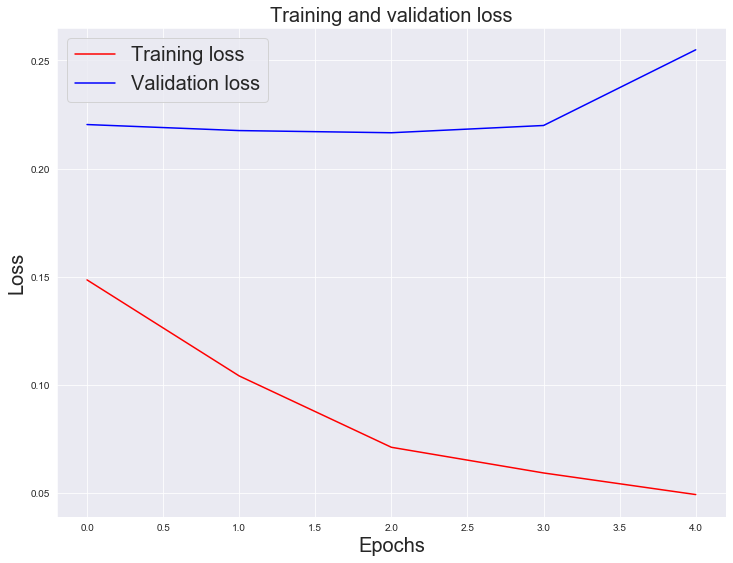

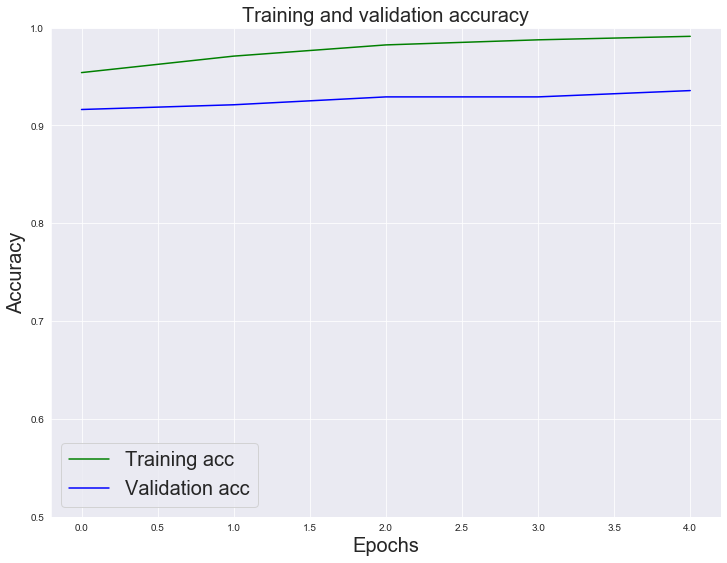

In [218]:
#Visualize our training over time
history_dict = model6_text.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = model6_text.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [219]:
#Evaluate the testing set
pred = model6.predict(x_test_text_rnn)
pred6_text = []

for i in pred:
    if i >= 0.5:
        pred6_text.append(1)
    else:
        pred6_text.append(0) 


f1_macro = f1_score(y_test, pred6_text, average = 'macro')
f1_micro = f1_score(y_test, pred6_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9040062145785674
microaveraged F1:  0.907860824742268
